# Import modules and notebook settings

In [1]:
# Keep modules updated if they change within the session
%load_ext autoreload
%autoreload 2

# Load modules
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import squidpy as sq
import anndata as ad
import scanpy as sc

# Settings
import warnings
warnings.filterwarnings('ignore')
#sc.settings.set_figure_params(dpi=80)

# Print versions
sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

2022-12-09 01:11:05.512258: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-09 01:11:05.705900: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-09 01:11:05.735030: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-09 01:11:05.735042: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.3 scipy==1.9.3 pandas==1.5.1 scikit-learn==1.1.3 statsmodels==0.13.5 python-igraph==0.9.11 louvain==0.7.2 pynndescent==0.5.8
squidpy==1.2.3


# Create AnnData object

### Current required structure for seamless functionality:
 
 - **Root folder** (e.g. Hartmann-2021)
     - **metadata.xlsx**
     - **experiment_folder/**        *(e.g. scMEP_MIBI_singlecell)*
         - **main_matrix.csv**        nested matrix with columns = ['point', 'cell_id', $markers ... , 'center_rowcoord', 'center_colcoord', 'cell_size', 'donor', 'category', 'Cluster', 'library_id']         (e.g. scMEP_MIBI_singlecell.csv)
         - **image_folder/**        *(e.g. scMEP_MIBI_colon_images)*
             - **donor_folders/**        1 folder per donor/sample; ==obs['donor'] !!!
                 - **point/FOV folders**        1 folder per point/FOV; == 'librarary_id'; names must not repeat across donors!; requires['cell_id', 'center_rowcoord', 'center_colcord', 'point', 'donor', 'library_id] *(e.g. Poin21, ..., Point32)*
                - image_files.tif        == markers/features/channels; names can repeat across donord; *(e.g. 147_vimentin.tif)*
         - **segmentation_folder/**        *(e.g. segmentation)*
              - **segmentation_files.tif**        requires obs['cell_id', 'point', 'donor', 'library_id']; *(e.g. Point1_Label_Map.tif)*

### Prepare the data

In [2]:
# Annotations come in a single matrix
data_unformatted = pd.read_csv("input-data/raw-data/Hartmann-2021/scMEP_MIBI_singlecell/scMEP_MIBI_singlecell.csv")
data_unformatted = data_unformatted.dropna(axis=0)

# Some manual matrix formatting
data_unformatted['library_id'] = 'Point' + data_unformatted['point'].astype(str)
data_unformatted['new_index'] = data_unformatted['library_id'].astype(str) + '_' + data_unformatted['cell_id'].astype(str)
data_unformatted = data_unformatted.set_index(pd.Index(data_unformatted['new_index'].to_numpy()))
data_unformatted = data_unformatted.drop('new_index', axis=1)
data_unformatted['center_colcoord'] = data_unformatted['center_colcoord'].apply(lambda x: 400 / 1024 * x)
data_unformatted['center_rowcoord'] = data_unformatted['center_rowcoord'].apply(lambda x: 400 / 1024 * x)

# Subset and format to adjust to AnnData format
counts = data_unformatted.iloc[:, 3:39]

## Due to AnnData bugs (2022-12-05) we need to either supply a numpy.array or recently created pandas.DataFrame
X = pd.DataFrame(
        counts.to_numpy(),
        columns = list(counts.columns),
        index = list(counts.index)
)
obs = data_unformatted.iloc[:, np.r_[0:3, 39:len(data_unformatted.columns)]]

# adata. obsm: Spatial location of spots
obsm = {
    'spatial': data_unformatted.loc[:, ['center_colcoord', 'center_rowcoord']].to_numpy()
}

# adata.uns: Metadata
sample_info = pd.read_excel(
    "input-data/raw-data/Hartmann-2021/scMEP_sample_description.xlsx",
).to_dict(orient='list')

uns = {
    'sample_info': sample_info,
    'Cluster_colors': [
        '#1f77b4',
        '#ff7f0e',
        '#2ca02c',
        '#d62728',
        '#9467bd',
        '#8c564b',
        '#e377c2',
        '#7f7f7f'
      ]
}


### Create the object

In [3]:
# Create AnnData object
adata = ad.AnnData(
    X = X, 
    obs = obs, 
    obsm = obsm,
    uns = uns
)

### View

In [4]:
adata.to_df()

H3  vimentin       SMA      CD98     NRF2p       CD4  \
Point7_2      0.785881  0.408300  0.696414  0.000000  0.600454  0.000000   
Point7_6      0.762130  0.727941  0.692685  0.000000  0.126400  0.000000   
Point7_8      0.718484  0.321032  0.270971  0.379427  0.728447  0.239057   
Point7_9      0.844099  0.595707  0.643885  0.334527  0.134485  0.531027   
Point7_14     0.733856  0.652953  0.461541  0.589736  0.484765  0.356065   
...                ...       ...       ...       ...       ...       ...   
Point25_1124  0.606688  0.693328  0.482057  0.000000  0.417442  0.348995   
Point25_1125  0.803571  0.704590  0.541540  0.543553  0.276144  0.571832   
Point25_1126  0.748780  0.485276  0.868089  0.000000  0.525238  0.263389   
Point25_1127  0.831164  0.812797  0.561337  0.101062  0.578004  0.136832   
Point25_1128  0.832389  0.566054  0.497770  0.279935  0.620042  0.358271   

                  CD14      CD45       PD1      CD31  ...       CD8      CD57  \
Point7_2      0.572489  0.071873  0.000000  0.000000  ...  0.000000  0.000000   
Point7_6      0.330630  0.474050  0.000000  0.000000  ...  0.468677  0.070334   
Point7_8      0.131221  0.192857  0.000000  0.000000  ...  0.033525  0.157202   
Point7_9      0.195556  0.670235  0.053552  0.000000  ...  0.114762  0.000000   
Point7_14     0.386779  0.439137  0.000000  0.287635  ...  0.019767  0.000000   
...                ...       ...       ...       ...  ...       ...       ...   
Point25_1124  0.499925  0.209032  0.000000  0.000000  ...  0.000000  0.000000   
Point25_1125  0.672874  0.727685  0.563716  0.000000  ...  0.000000  0.000000   
Point25_1126  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
Point25_1127  0.034396  0.000000  0.000000  0.885439  ...  0.000000  0.000000   
Point25_1128  0.488144  0.246632  0.000000  0.000000  ...  0.000000  0.000000   

                  LDHA      IDH2       HK1      Ecad     CPT1A        CK  \
Point7_2      0.344579  0.502285  0.161829  0.269818  0.324649  0.000000   
Point7_6      0.409235  0.481462  0.312938  0.094715  0.354284  0.000000   
Point7_8      0.537986  0.543015  0.091759  0.322762  0.443656  0.284286   
Point7_9      0.609270  0.499102  0.479794  0.294011  0.444598  0.000000   
Point7_14     0.618623  0.557943  0.384368  0.477327  0.559286  0.396537   
...                ...       ...       ...       ...       ...       ...   
Point25_1124  0.648503  0.507011  0.117075  0.351623  0.378172  0.000000   
Point25_1125  0.663256  0.624918  0.662077  0.394823  0.406933  0.000000   
Point25_1126  0.599062  0.625642  0.426509  0.393277  0.447733  0.000000   
Point25_1127  0.650302  0.668709  0.349704  0.379485  0.453863  0.000000   
Point25_1128  0.663211  0.505957  0.215997  0.234392  0.558448  0.000000   

              NaKATPase     HIF1A  
Point7_2       0.000000  0.000000  
Point7_6       0.000000  0.000000  
Point7_8       0.447547  0.000000  
Point7_9       0.256981  0.106809  
Point7_14      0.682852  0.204079  
...                 ...       ...  
Point25_1124   0.459636  0.000000  
Point25_1125   0.494732  0.000000  
Point25_1126   0.000000  0.000000  
Point25_1127   0.336142  0.000000  
Point25_1128   0.040020  0.000000  

[63734 rows x 36 columns]

In [5]:
adata.obs

row_num  point  cell_id       X1  center_rowcoord  \
Point7_2            0      7        2  63894.0        42.578125   
Point7_6            3      7        6  63898.0       330.078125   
Point7_8            4      7        8  63900.0       389.453125   
Point7_9            5      7        9  63901.0        75.000000   
Point7_14           9      7       14  63906.0       356.640625   
...               ...    ...      ...      ...              ...   
Point25_1124    66394     25     1124  50571.0       347.656250   
Point25_1125    66395     25     1125  50572.0       192.187500   
Point25_1126    66396     25     1126  50573.0       241.406250   
Point25_1127    66397     25     1127  50574.0        25.390625   
Point25_1128    66398     25     1128  50575.0       364.453125   

              center_colcoord  cell_size   category donor       Cluster  \
Point7_2             2.343750      277.0  carcinoma  90de     Imm_other   
Point7_6             1.953125      298.0  carcinoma  90de     Imm_other   
Point7_8             6.640625     2037.0  carcinoma  90de    Epithelial   
Point7_9             5.078125      611.0  carcinoma  90de     Tcell_CD4   
Point7_14            6.640625     1616.0  carcinoma  90de  Myeloid_CD68   
...                       ...        ...        ...   ...           ...   
Point25_1124       396.875000      219.0  carcinoma  21d7     Imm_other   
Point25_1125       397.656250      238.0  carcinoma  21d7     Tcell_CD4   
Point25_1126       398.046875      283.0  carcinoma  21d7    Fibroblast   
Point25_1127       398.046875      138.0  carcinoma  21d7   Endothelial   
Point25_1128       398.046875      110.0  carcinoma  21d7     Imm_other   

             library_id  
Point7_2         Point7  
Point7_6         Point7  
Point7_8         Point7  
Point7_9         Point7  
Point7_14        Point7  
...                 ...  
Point25_1124    Point25  
Point25_1125    Point25  
Point25_1126    Point25  
Point25_1127    Point25  
Point25_1128    Point25  

[63734 rows x 11 columns]

In [6]:
adata.obsm

AxisArrays with keys: spatial

In [7]:
adata.uns.keys()

dict_keys(['sample_info', 'Cluster_colors'])

# Integrate image and segmentation mask data

### User input

*Previous to **commit e03e83d38317f2ca379851badd8b0f6896474f94**, the input was based on a single sample folder, containing one folder per point/FOV, containing all the image files (.tiff) of each channel*

In [8]:
# The user must choose 3 fluorophore channels to use as RGB raster format
user_input_channels = ['145_CD45', '174_CK', '113_vimentin']
image_dir = "input-data/raw-data/Hartmann-2021/scMEP_MIBI_singlecell/scMEP_MIBI_colon_images/90de_tumor/"
segmentation_dir = "input-data/raw-data/Hartmann-2021/scMEP_MIBI_singlecell/segmentation/"

### Algorithm initiation and adding images

 - This algorithm processes both images and segmentation masks separately
 - It also checks that the file names are correctly attributed based on `obs['library_id']`

In [9]:
image_dir = 'input-data/raw-data/Hartmann-2021/scMEP_MIBI_singlecell/scMEP_MIBI_colon_images/'

# Initialize the spatial dictionary
spatial_dict = {}

# Some variables
library_ids = adata.obs['library_id'].unique()

for donor in os.listdir(image_dir):

    donor_path = os.path.join(image_dir, donor)

    # Check if folder structure correct: layer 1
    if not os.path.isdir(donor_path):
        raise Exception('`image_dir` directory must only contain directories named after the donors.')
    
    # Check if folder names coincide with donor value in obs matrix
    elif not all(np.in1d(donor, adata.obs['donor'].to_list())):
        raise Exception('First layer folders are not named as in obs[\'donor\']')
    
    else:

        # Define points/FOV
        points = sorted(os.listdir(donor_path))

        # Check that point names are found in the `obs['library_id']`
        if not all(np.in1d(points, library_ids)):
            raise Exception("Image file names must be named equal to library_ids")




        # Add images
        
        for point in points:
    
            # Init dict layer 1: 'library_id' = {images, scalefactors}
            spatial_dict[point] = {}

            # Init dict layer 2: 'images' = {hires, segmentation}
            spatial_dict[point]['images'] = {}
    
            # Fill 'image' key in layer 2
            # 3 channel images as RGB raster 
            # Read .tif data as array
            # Can also be done with scipy or python image library PIL
            channel_arr = np.array(
                [
                    plt.imread(os.path.join(donor_path, point, user_input_channels[0]) + ".tif"),
                    plt.imread(os.path.join(donor_path, point, user_input_channels[1]) + ".tif"),
                    plt.imread(os.path.join(donor_path, point, user_input_channels[2]) + ".tif")
                ]
            ).transpose(1, 2, 0)
    
            spatial_dict[point]['images']['hires'] = channel_arr
    
            # Fill 'scalefactors' key in layer 1
            spatial_dict[point]['scalefactors'] = {
                'spot_diameter_fullres': 7,
                'tissue_hires_scalef': 1024/400,
            }

### Add segmentation data

- This algorithm processes both images and segmentation masks separately
- Checks the validity of the segmentation files by trying to attribute the their names to the corresponding image file names by string content.

- In the future maybe integrate two alterntive paths:
    - argument indicating a dictionary of file links
    - argument indicating the file name changes/presuffixes that apply to the image file name to arrive at the segmentation file name

In [10]:
# Check if segmentation file names contain the library_id
seg_files = sorted(os.listdir(segmentation_dir))

## Initiate segmentation-file-name to library_id dict
dict_seg_lib_id = {}

for seg_file in seg_files:

    seg_id = seg_file[:-15] ### !!! Can be improved via e.g. regular expressions

    if seg_id in set(library_ids):
        dict_seg_lib_id[seg_file] = seg_id

    else:
        raise Exception('All segmentation files must contain the of an image file which are based on obs[\'library_id\']')


# Add segmentation information
for key, value in dict_seg_lib_id.items():

    # Fill 'segmentation' key in layer 2
    spatial_dict[value]['images']['segmentation'] = plt.imread(segmentation_dir + key)
    
    # Add 'tissue_segmentation_scalef' key in layer 1
    spatial_dict[value]['scalefactors']['tissue_segmentation_scalef'] = 1

### Final integration

In [11]:
# Integrate spatial dictionary into adata
adata.uns['spatial'] = spatial_dict

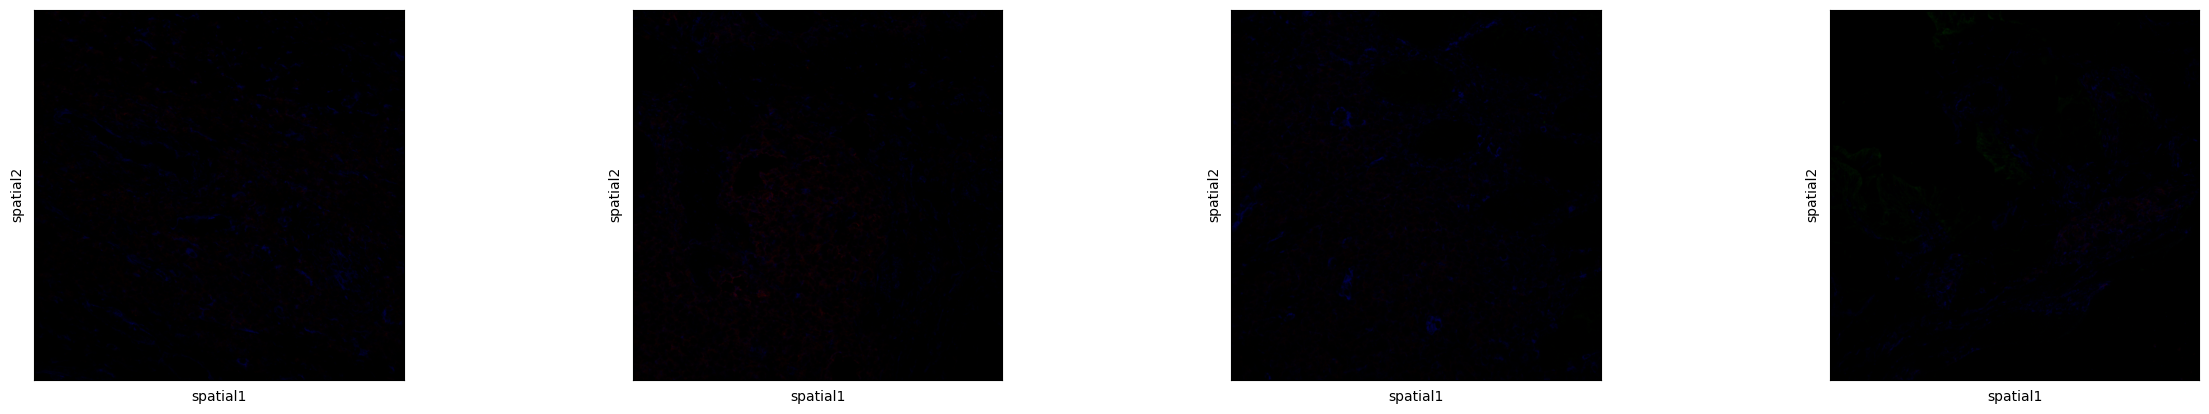

In [12]:
sq.pl.spatial_scatter(adata, color=[None], library_key='library_id', library_id=['Point1', 'Point21', 'Point41', 'Point45'])

# Visualize

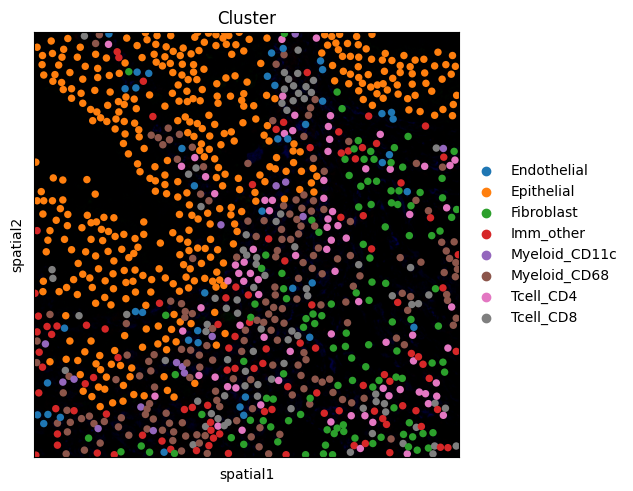

In [13]:
sq.pl.spatial_scatter(adata, color=['Cluster'], library_key='library_id', library_id=['Point8'])

### Segmentation mask

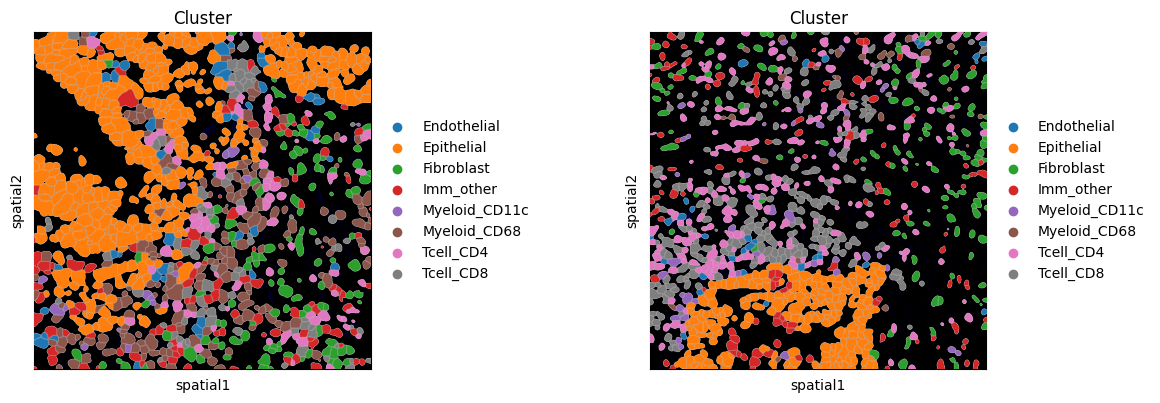

In [14]:
sq.pl.spatial_segment(adata, library_key='library_id', library_id=['Point8', 'Point16'], seg_cell_id='cell_id', color='Cluster')

### Expression under mask

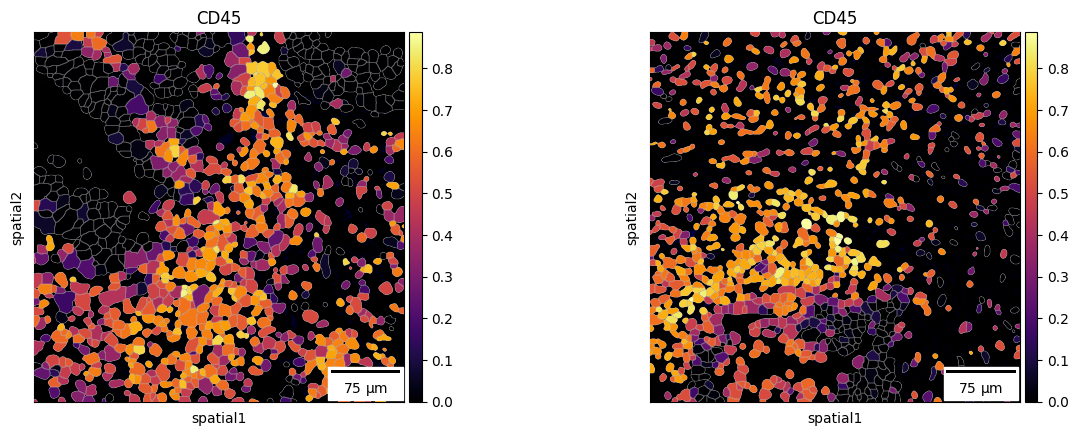

In [15]:
sq.pl.spatial_segment(
    adata,
    color='CD45', # Immune cell marker (differentiated)
    library_key='library_id',
    library_id=['Point8', 'Point16'],
    seg_cell_id='cell_id',
    cmap='inferno',
    scalebar_dx=400/1024,
    scalebar_kwargs={'scale_loc': 'bottom', 'location': 'lower right'}
)

# Expression of some specific markers

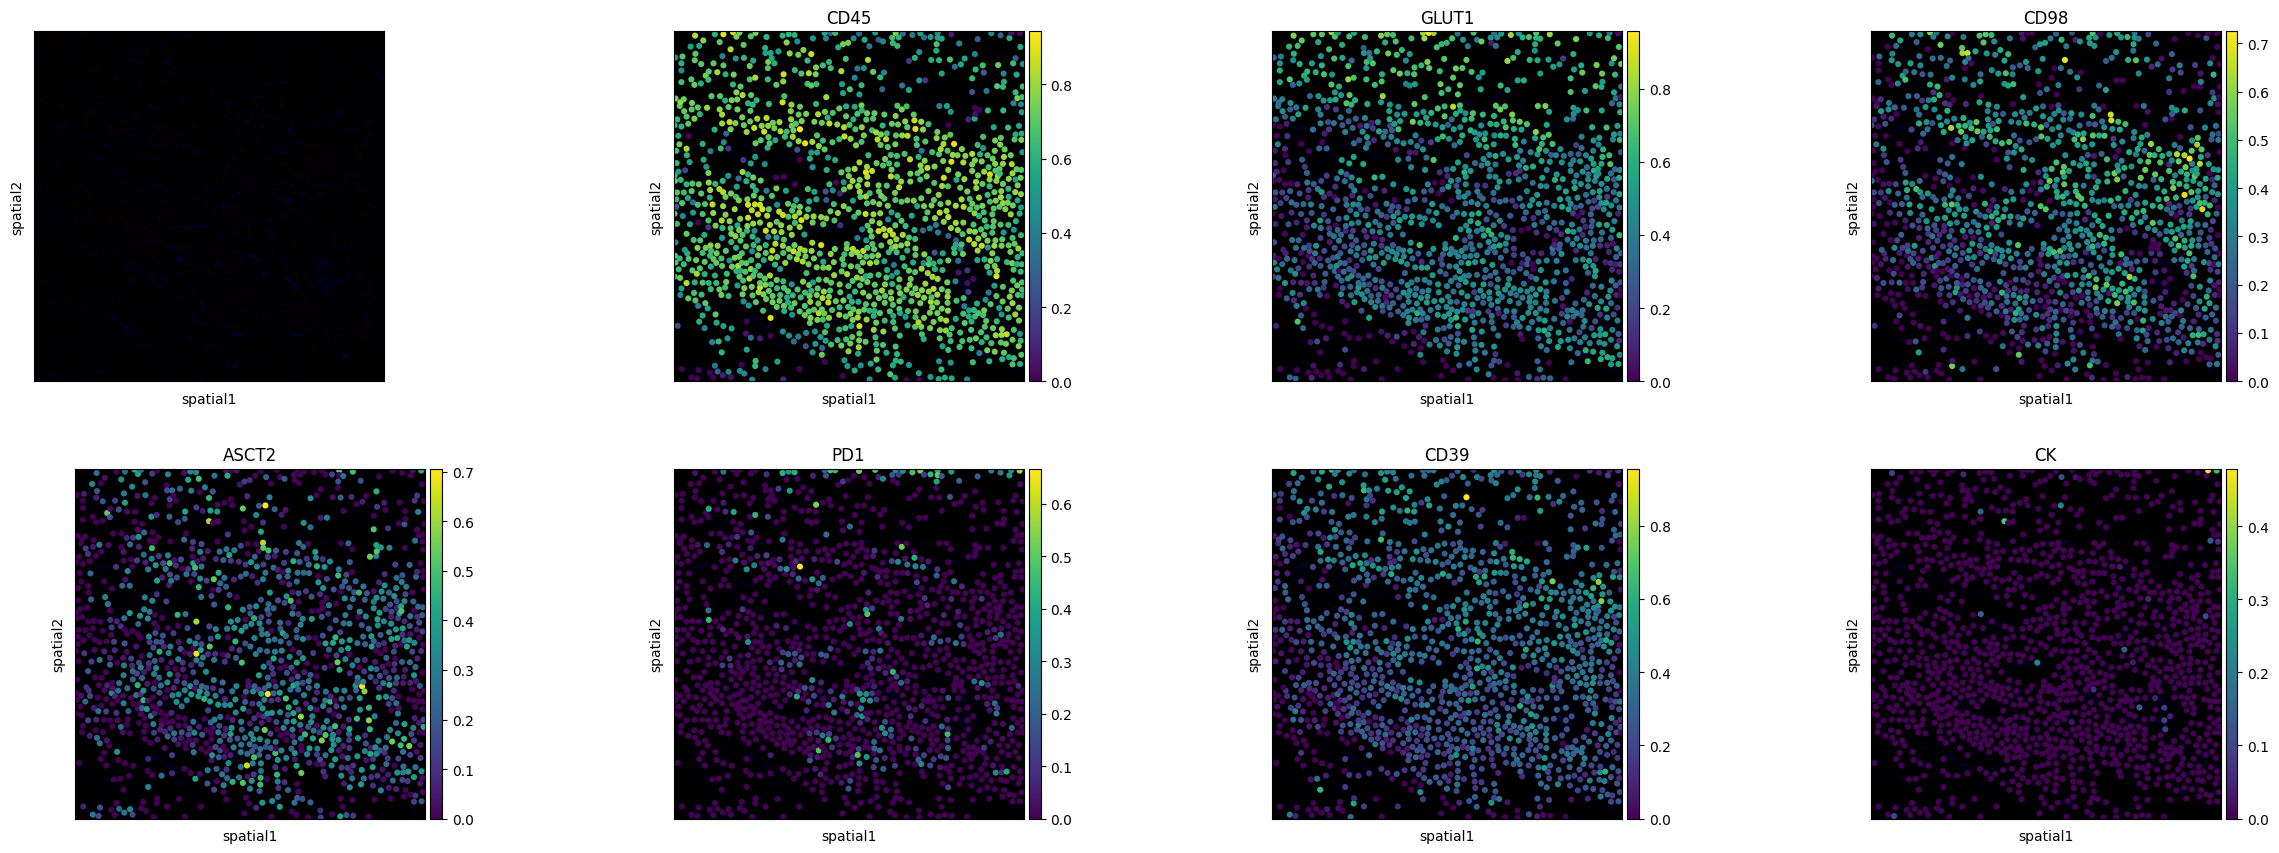

In [16]:
sq.pl.spatial_scatter(
    adata,
    color=[None,
           'CD45', # Hematopoietic cells (differentiated)
           'GLUT1', # Glucose transporter
           'CD98', # Amino acid transporter, auth: found polarized towards tumour-immune border
           'ASCT2', # -||-
           'PD1', # Immune activation marker
           'CD39', # -||-
           'CK', # Cancer marker
           ],
    library_key='library_id',
    library_id='Point1')

# Save adata object

In [17]:
adata.write('output-data/Hartmann-2021/hartmann.h5ad', compression='gzip')

# Subset for certain methods

In [37]:
adata_8 = adata[adata.obs['point']==8]
adata_8

View of AnnData object with n_obs × n_vars = 1045 × 36
    obs: 'row_num', 'point', 'cell_id', 'X1', 'center_rowcoord', 'center_colcoord', 'cell_size', 'category', 'donor', 'Cluster', 'library_id'
    uns: 'sample_info', 'Cluster_colors', 'spatial', 'spatial_neighbors', 'Cluster_co_occurrence', 'Cluster_interactions'
    obsm: 'spatial'
    obsp: 'spatial_connectivities', 'spatial_distances'

# Compute spatial neighbours graph

In [38]:
sq.gr.spatial_neighbors(adata_8, n_neighs=10, coord_type='generic')

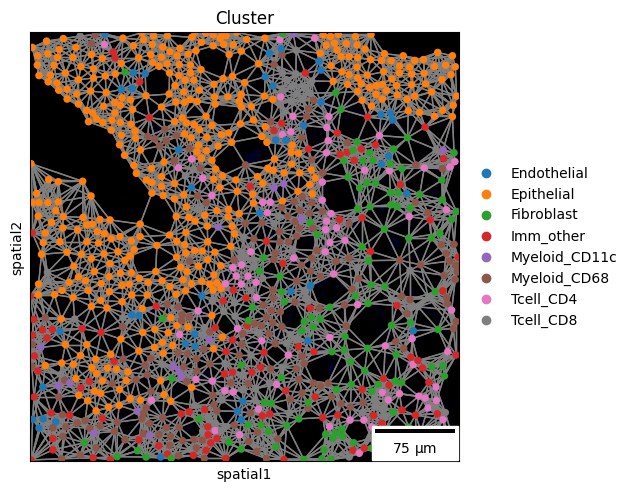

In [44]:
# No edges shown?
sq.pl.spatial_scatter(
    adata_8,
    color='Cluster',
    library_key='library_id',
    library_id='Point8',
    connectivity_key='spatial_connectivities',
    edges_width=1,
    scalebar_dx=400/1024,
    scalebar_kwargs={"scale_loc": "bottom", "location": "lower right"},
)

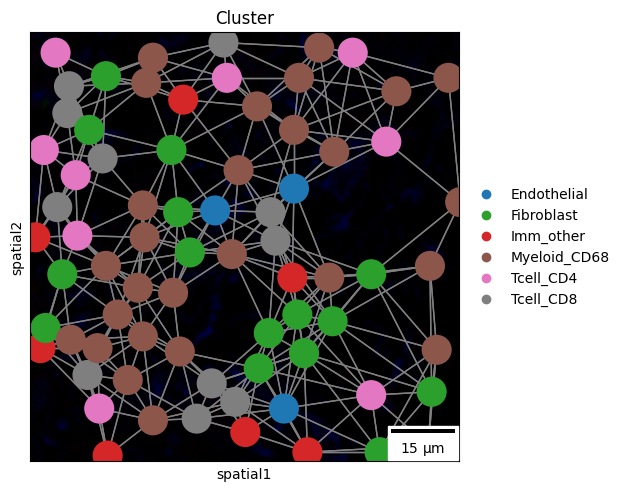

In [45]:
# No edges shown?
sq.pl.spatial_scatter(
    adata_8,
    color='Cluster',
    library_key='library_id',
    library_id='Point8',
    connectivity_key='spatial_connectivities',
    edges_width=1,
    scalebar_dx=400/1024,
    scalebar_kwargs={"scale_loc": "bottom", "location": "lower right"},
    crop_coord=[(200, 200, 300, 300)],
)

# Interaction matrix

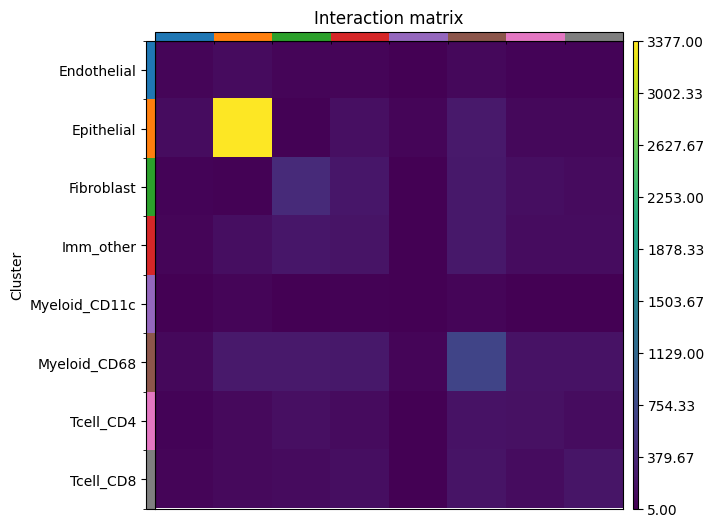

In [46]:
sq.gr.interaction_matrix(adata_8, cluster_key='Cluster')
sq.pl.interaction_matrix(adata_8, cluster_key='Cluster')

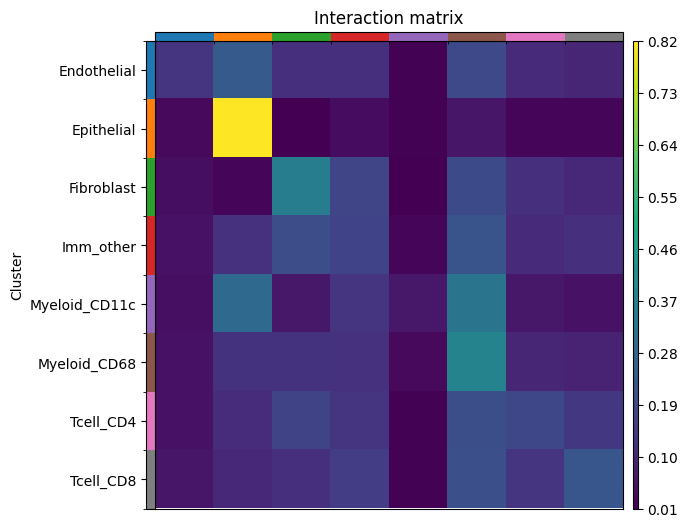

In [47]:
sq.gr.interaction_matrix(adata_8, cluster_key='Cluster', normalized=True)
sq.pl.interaction_matrix(adata_8, cluster_key='Cluster')

# Co-occurence probability

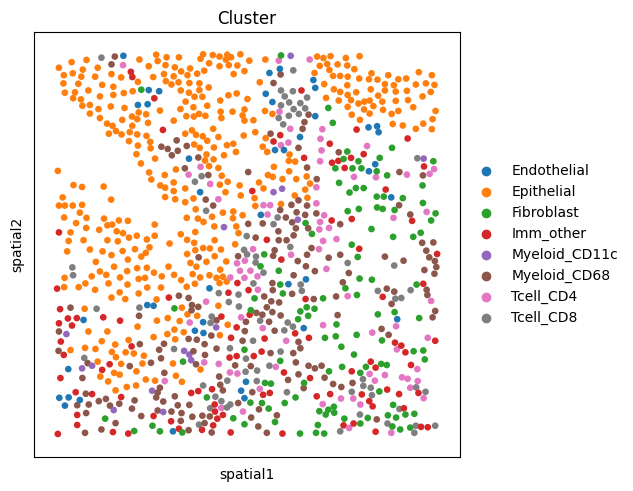

In [50]:
sq.pl.spatial_scatter(adata, color='Cluster', library_key='library_id', library_id=['Point8'], img=None)

In [48]:
sq.gr.co_occurrence(adata_8, cluster_key='Cluster', n_jobs=16)

100%|██████████| 1/1 [00:03<00:00,  3.64s/]


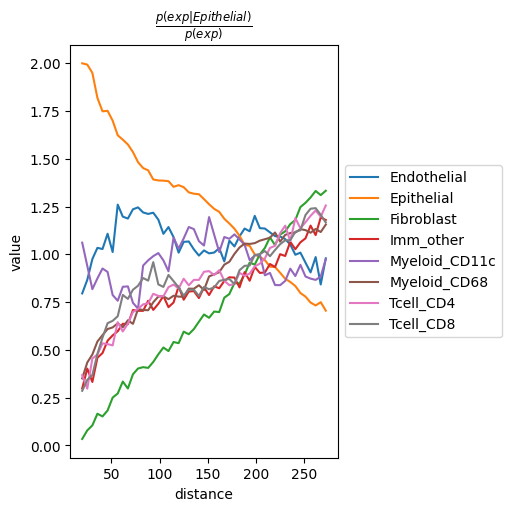

In [52]:
sq.pl.co_occurrence(adata_8, cluster_key='Cluster', clusters='Epithelial')

# NCEM

Output:
 - Coupling analysis: DEGs
 - Coupling analysis circular: DEGs or magnitude
 - Sender effect on receiving cell
 - Sender-receiver vulcano plot
 - **Sender similarity analysis**

Not functioning:
 - Grid searches over neighbourhood sizes + Length scales of dependencies for different target cell-types
 - (Squidpy CellPhoneDB)

Outlook:
- Future custom loader


In [ ]:
import ncem

### 0. Loading the data with the predefined data loader

In [ ]:
interpreter = ncem.interpretation.interpreter.InterpreterInteraction()
interpreter.get_data(
    data_origin='hartmann', # Reference to specfic DataLoader (see notes in Dropbox paper)
    data_path='input-data/raw-data/Hartmann-2021/',
    radius=35,
    node_label_space_id='type',
    node_feature_space_id='standard',
)
print('\n Celldata metadata:', interpreter.data.celldata.uns['metadata'])

In [ ]:
# node degrees for different radii
interpreter.data.plot_degree_vs_dist(
    max_distances=[0, 10, 50, 200, 1000],
    lateral_resolution=400/1024, # Physical cell resolution
)

### 2. Extracting sender-receiver effects with NCEM

In [ ]:
# splitting data into test and validation sets, can be ignored for non sender-receiver focused analysis
interpreter.split_data_node(0.1, 0.1)
interpreter.n_eval_nodes_per_graph = 10
interpreter.cell_names = list(interpreter.data.celldata.uns['node_type_names'].values())

In [ ]:
interpreter.get_sender_receiver_effects()

### Type coupling analysis

Heatmap color is proportional to the number of differentially expressed genes at a FDR-corrected p-value threshold of 0.05 for each pair of sender and receiver cell types. 

In [ ]:
interpreter.type_coupling_analysis(figsize=(6.5, 5.5))

Edge width proportional to the number of differentially expressed genes at a FDR-corrected p-value threshold of 0.05 for each pair of sender and receiver cell types. Only edges with eat least 24 differentially expressed genes are shown.


**Arrow thickness:** strength of directional dependencies between cell types as the magnitude of the corresponding coefficient vector

In [ ]:
interpreter.type_coupling_analysis_circular(
    edge_attr='magnitude', # IDF: Alternatives should be: ["magnitude", 'de_genes', 'de_genes_abs']
    edge_width_scale=3.5,
    de_genes_threshold=24,
    figsize=(9,9),
    text_space=1.35
)

### IDF: edge thickness = #(DEGs) to relate to the coupling analysis heatmap

In [ ]:
interpreter.type_coupling_analysis_circular(
    edge_attr='de_genes',
    edge_width_scale=3.5,
    de_genes_threshold=1,
    figsize=(9,9),
    text_space=1.35
)

### 3. Directional sender effects for Epithelial cells and CD8 T cells

We dissected these couplings based on the gene-wise effects of all senders on one receiver type for CD8T cells and Epithelial cells which contextualizes differential expression results of the CD8T cell–Epithelial cell axis.

NCEM correctly identifies genes and proteins that play roles in T-cell activation, regulation of T-cell antigen receptor signalling and immune response.

### a) Sender effects on CD8 T cells 

“Sender effect” analysis heatmap for CD8 T cells. Shown is the estimated log fold change that the sender cell type on the x-axis induces in the gene on the y axis in receiving CD8 T cells.

In [ ]:
interpreter.sender_effect(
    receiver='CD8 T cells', 
    gene_subset=['CD8A', 'CD4', 'PTPRC', 'ENTPD1', 'PDCD1', 'CD247'], 
    figsize=(4,5)
)

### b) Sender effects on Epithelial cells

“Sender effect” analysis heatmap for Epithelial cells. Shown is the estimated log fold change that the sender cell type on the y-axis induces in the gene on the x axis in receiving Epithelial cells.

In [ ]:
interpreter.sender_effect(
    receiver='Epithelial', 
    gene_subset=['CD8A', 'CD4', 'PTPRC', 'ENTPD1', 'PDCD1', 'CD247'], 
    figsize=(4,5)
)

### c) Directional effect for sender-receiver axis for CD8 T cells on Epithelial cells 

This analysis contextualizes differential expression results of the CD8 Tcell – Epithelial cell axis.

Volcano plot of differentially expressed genes of Epithelial cells in the neighborhood of CD8 T cells.

In [ ]:
interpreter.sender_receiver_effect_vulcanoplot(
    sender='CD8 T cells', 
    receiver='Epithelial',
    fold_change_threshold=0.04,
    figsize=(3,5)
)

In [ ]:
# low fold change
interpreter.sender_receiver_values(
    sender='CD8 T cells', 
    receiver='Epithelial'
).sort_values(by='fold change').head(5)

In [ ]:
# high fold change
interpreter.sender_receiver_values(
    sender='CD8 T cells', 
    receiver='Epithelial'
).sort_values(by='fold change', ascending=False).head(5)

### 4. Sender similarity analysis for Epithelial cells

“Sender similarity analysis” of all sender cell types with respect to Epithelial cell receivers. Shown is a clustered heatmap of Pearson correlation coefficients of the coefficient vectors of each sender type that corresponds to Epithelial cell receivers.

T cell clusters and other immune cells had a similar effect on Epithelial cells in a “sender similarity analysis”, in which we correlated the coefficient vectors of sender cell types that correspond to Epithelial cell receivers, which demonstrates conservation of cell type identity in the sender profile.

In [ ]:
interpreter.sender_similarity_analysis(receiver='Epithelial')